# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

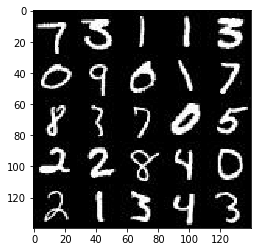

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

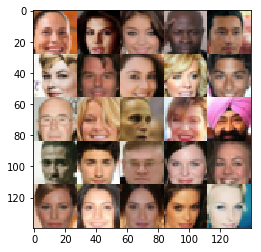

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                [None, image_width, image_height, image_channels], 
                                name = 'inputs_real')
    
    inputs_z = tf.placeholder(tf.float32, 
                              [None, z_dim], 
                              name = 'inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [108]:
def leaky_relu(x, alpha = 0.2):
    """
    implement leaky_relu op
    """
    return tf.maximum(alpha * x, x)

def get_kernel_init():
    """
    implement kernel initializer
    """
    return  tf.contrib.layers.xavier_initializer()

def conv2d_bn_lkrelu(x, out_channels, ksize, strides, padding, 
                     kernel_init = None, 
                     use_bn = True, 
                     training = True):
    """
    implement conv2d - batch_norm - leaky_relu layer
    """
    conv = tf.layers.conv2d(x, out_channels, ksize, 
                            strides=strides, padding=padding, kernel_initializer=kernel_init)
    
    if use_bn:
        bn = tf.contrib.layers.batch_norm(conv, 
                                          center=True, scale=True,
                                          is_training = training)
        
#         bn = tf.layers.batch_normalization(conv, training=training)
        return leaky_relu(bn)

    return leaky_relu(conv)

def conv2dtrans_bn_lkrelu( x, out_channels, ksize, strides, padding, 
                           kernel_init = None, 
                           use_bn = True, 
                           training = True):
    """
    implement conv2d_transpose - batch_norm - leaky_relu layer
    """    
    conv_trans = tf.layers.conv2d_transpose(x, out_channels, ksize, 
                                            strides=strides, padding=padding, kernel_initializer=kernel_init)
    
    if use_bn:
        bn = tf.contrib.layers.batch_norm(conv_trans, 
                                          center=True, scale=True,
                                          is_training = training)
#         bn = tf.layers.batch_normalization(conv_trans, training=training)
        
        return leaky_relu(bn)

    return leaky_relu(conv_trans)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # define some models parameter
    ksize = 5
    kernel_init = get_kernel_init()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st layer: 14x14x64
        # Note here we don't use batch-norm (learn from GAN lectures)
        x1 = conv2d_bn_lkrelu(images, 64, ksize, strides=2, padding='same', 
                              kernel_init=kernel_init, use_bn = False)
        
        x1 = tf.nn.dropout(x1, keep_prob=0.75)
        
        # 2nd layer: 7x7x128
        x2 = conv2d_bn_lkrelu(x1, 128, ksize, strides=2, padding='same',
                              kernel_init=kernel_init, use_bn = True) 
        
        x2 = tf.nn.dropout(x2, keep_prob=0.75)
        
        # 3rd layer: 4x4x256
        x3 = conv2d_bn_lkrelu(x2, 256, 4, strides=1, padding='valid',
                              kernel_init=kernel_init, use_bn = True) 
        
        x3 = tf.nn.dropout(x3, keep_prob=0.75)
        
        # 4rd layer: 2x2x256
        x4 = conv2d_bn_lkrelu(x3, 512, 4, strides=2, padding='same',
                              kernel_init=kernel_init, use_bn = True)
        
        x4 = tf.nn.dropout(x4, keep_prob=0.75)
        
        # hidden linear layer
        flat = tf.contrib.layers.flatten(x4)
        logits = tf.layers.dense(flat, 1, activation=None)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [75]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # define some models parameter
    ksize = 5
    kernel_init = get_kernel_init()
    
    with tf.variable_scope('generator', reuse=not is_train):
        # 1st fully-connected layer
        x1 = tf.layers.dense(z, 2*2*512, activation=None, kernel_initializer = kernel_init)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        
        x1 = leaky_relu(x1)   # 2x2x512
        
        # 2nd layer: tranposed conv2d 4x4x256
        x2 = conv2dtrans_bn_lkrelu(x1, 256, 4, strides=2, padding='same',
                                   kernel_init=kernel_init, use_bn = True, training=is_train)
        
        # 3rd layer: tranposed conv2d 7x7x128
        x3 = conv2dtrans_bn_lkrelu(x2, 128, 4, strides=1, padding='valid',
                                   kernel_init=kernel_init, use_bn = True, training=is_train)
        
        # 4th layer: transpose conv2d 14x14x64       
        x4 = conv2dtrans_bn_lkrelu(x3, 64, ksize, strides=2, padding='same',
                                   kernel_init=kernel_init, use_bn = True, training=is_train)
        
        # output layer with tanh activation
        outputs = tf.layers.conv2d_transpose(x4, out_channel_dim, ksize, strides=2, padding='same',
                                             kernel_initializer = kernel_init, activation = tf.tanh)
        
    
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [59]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    smooth = 0.1
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # using smoothing here to make discriminator generalize better
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                        logits = d_logits_real,
                                        labels = tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                         labels = tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                    labels = tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [110]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # this part can re-used from DCGAN lecture
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [91]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = (1 if data_image_mode=='L' else 3)
    
    # inputs real & random & learning rate
    inputs_real, inputs_z, lr = model_inputs(*data_shape[1:],z_dim)
    
    # loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    
    # train opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # counter
    steps = 0
    show_every = 100
    n_images = 16
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for inputs_z
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                
                # scale input to -1, 1
                scaled_images = 2.0*batch_images
                
                # Run optimizers for discriminator
                _, train_loss_d = sess.run([d_train_opt, d_loss], feed_dict={inputs_real : scaled_images, 
                                                                             inputs_z : batch_z})
                
                # run train-op for generator twice
                _, train_loss_g = sess.run([g_train_opt, g_loss], feed_dict={inputs_real : scaled_images, 
                                                                             inputs_z : batch_z})
                _, train_loss_g = sess.run([g_train_opt, g_loss], feed_dict={inputs_real : scaled_images, 
                                                                             inputs_z : batch_z})
                
                if (steps % show_every == 0):
                    # after each show_every stpes we measure d_loss v.s g_loss
                    print("Epoch ({:>3d}/{:<3d})".format(epoch_i+1, epoch_count),
                          "Steps ({:>5d})".format(steps),
                          "Discriminator vs Generator Loss: {:7.4f} vs {:7.4f}".format(train_loss_d,
                                                                                       train_loss_g))
                    
                    print("Generated images")
                    show_generator_output(sess, n_images, inputs_z, out_channel_dim, data_image_mode)
            
            # show image at the last epoch 
            if (epoch_i+1==epoch_count):
                print("Done training, final images generated by model:")
                show_generator_output(sess, n_images, inputs_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch (  1/2  ) Steps (  100) Discriminator vs Generator Loss:  1.4809 vs  1.9749
Generated images


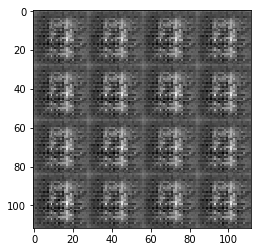

Epoch (  1/2  ) Steps (  200) Discriminator vs Generator Loss:  1.1248 vs  1.4720
Generated images


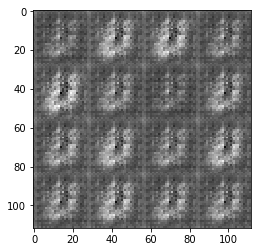

Epoch (  1/2  ) Steps (  300) Discriminator vs Generator Loss:  1.6356 vs  1.7555
Generated images


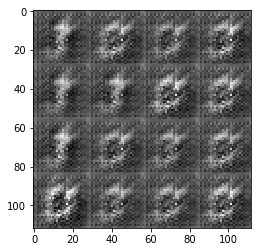

Epoch (  1/2  ) Steps (  400) Discriminator vs Generator Loss:  1.0448 vs  1.2753
Generated images


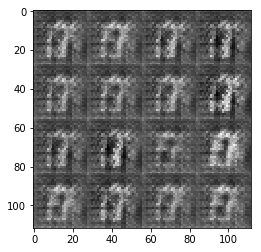

Epoch (  1/2  ) Steps (  500) Discriminator vs Generator Loss:  0.9818 vs  1.3007
Generated images


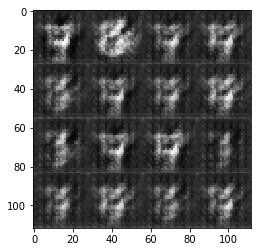

Epoch (  1/2  ) Steps (  600) Discriminator vs Generator Loss:  1.1738 vs  1.0775
Generated images


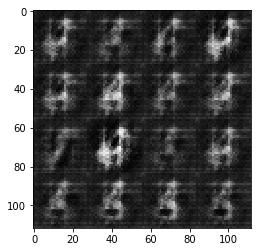

Epoch (  1/2  ) Steps (  700) Discriminator vs Generator Loss:  1.4043 vs  1.2932
Generated images


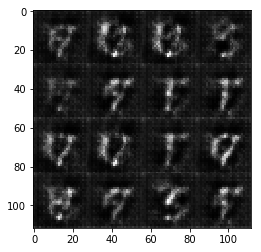

Epoch (  1/2  ) Steps (  800) Discriminator vs Generator Loss:  1.1680 vs  1.6578
Generated images


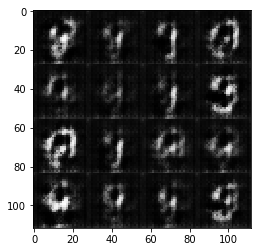

Epoch (  1/2  ) Steps (  900) Discriminator vs Generator Loss:  1.2375 vs  0.9570
Generated images


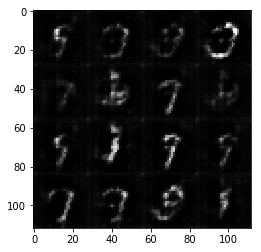

Epoch (  1/2  ) Steps ( 1000) Discriminator vs Generator Loss:  1.0589 vs  1.3030
Generated images


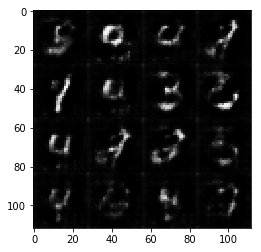

Epoch (  1/2  ) Steps ( 1100) Discriminator vs Generator Loss:  1.4521 vs  1.1067
Generated images


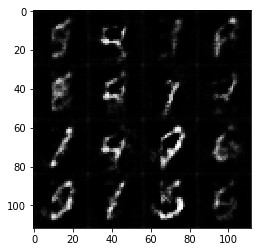

Epoch (  1/2  ) Steps ( 1200) Discriminator vs Generator Loss:  1.3674 vs  0.8715
Generated images


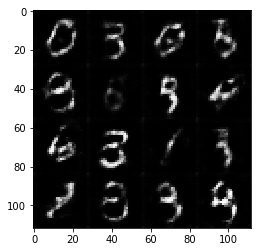

Epoch (  1/2  ) Steps ( 1300) Discriminator vs Generator Loss:  1.5336 vs  0.8243
Generated images


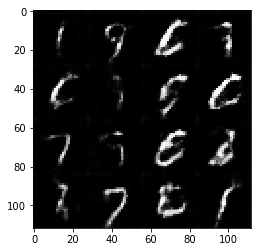

Epoch (  1/2  ) Steps ( 1400) Discriminator vs Generator Loss:  1.3890 vs  0.9516
Generated images


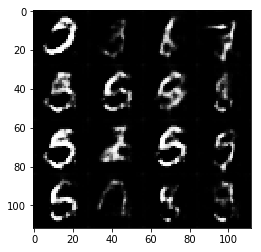

Epoch (  1/2  ) Steps ( 1500) Discriminator vs Generator Loss:  1.2354 vs  0.8175
Generated images


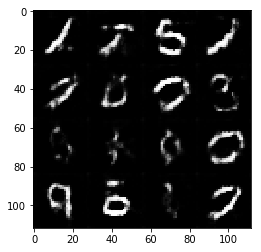

Epoch (  1/2  ) Steps ( 1600) Discriminator vs Generator Loss:  1.2484 vs  1.4358
Generated images


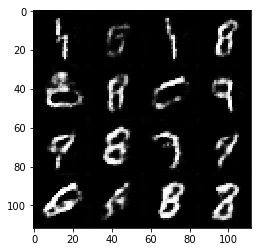

Epoch (  1/2  ) Steps ( 1700) Discriminator vs Generator Loss:  1.3052 vs  0.9618
Generated images


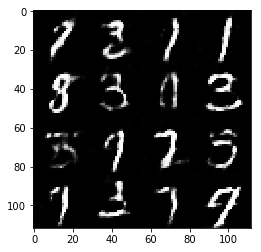

Epoch (  1/2  ) Steps ( 1800) Discriminator vs Generator Loss:  1.2749 vs  0.6045
Generated images


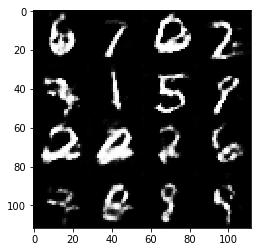

Epoch (  1/2  ) Steps ( 1900) Discriminator vs Generator Loss:  1.3448 vs  0.9145
Generated images


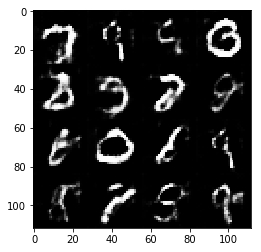

Epoch (  1/2  ) Steps ( 2000) Discriminator vs Generator Loss:  1.3385 vs  0.9948
Generated images


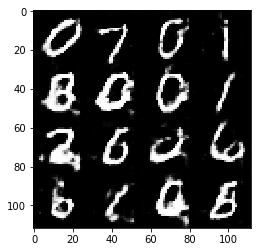

Epoch (  1/2  ) Steps ( 2100) Discriminator vs Generator Loss:  1.1158 vs  1.4716
Generated images


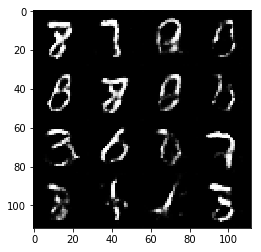

Epoch (  1/2  ) Steps ( 2200) Discriminator vs Generator Loss:  1.1061 vs  1.2452
Generated images


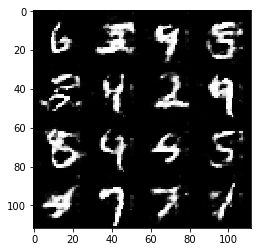

Epoch (  1/2  ) Steps ( 2300) Discriminator vs Generator Loss:  1.0410 vs  1.0543
Generated images


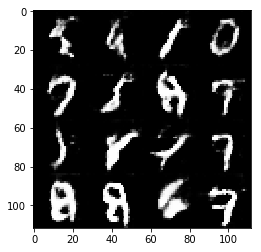

Epoch (  1/2  ) Steps ( 2400) Discriminator vs Generator Loss:  1.1772 vs  1.2108
Generated images


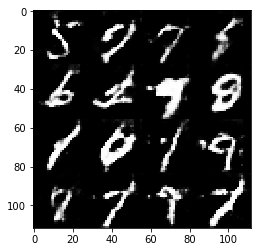

Epoch (  1/2  ) Steps ( 2500) Discriminator vs Generator Loss:  1.1813 vs  1.7737
Generated images


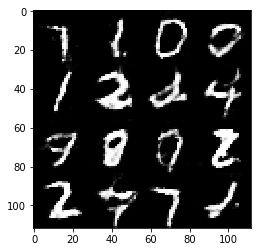

Epoch (  1/2  ) Steps ( 2600) Discriminator vs Generator Loss:  0.7546 vs  0.9906
Generated images


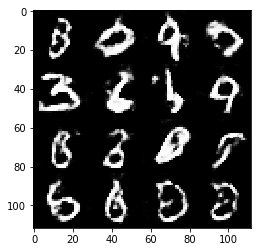

Epoch (  1/2  ) Steps ( 2700) Discriminator vs Generator Loss:  0.9688 vs  0.9717
Generated images


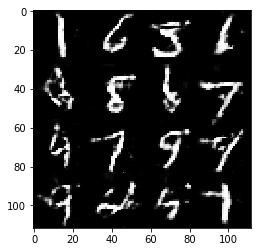

Epoch (  1/2  ) Steps ( 2800) Discriminator vs Generator Loss:  0.8604 vs  1.3658
Generated images


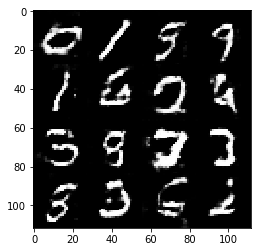

Epoch (  1/2  ) Steps ( 2900) Discriminator vs Generator Loss:  1.0339 vs  0.9776
Generated images


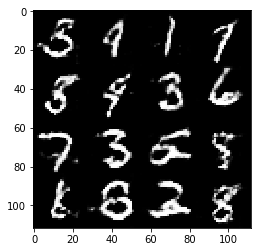

Epoch (  1/2  ) Steps ( 3000) Discriminator vs Generator Loss:  1.0434 vs  1.8566
Generated images


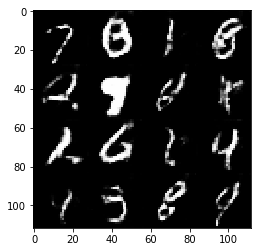

Epoch (  1/2  ) Steps ( 3100) Discriminator vs Generator Loss:  2.2865 vs  1.9957
Generated images


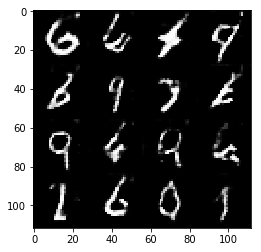

Epoch (  1/2  ) Steps ( 3200) Discriminator vs Generator Loss:  0.5292 vs  2.1585
Generated images


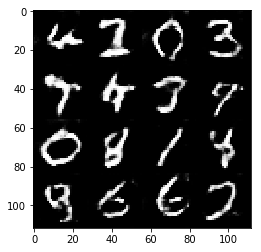

Epoch (  1/2  ) Steps ( 3300) Discriminator vs Generator Loss:  1.4449 vs  1.6274
Generated images


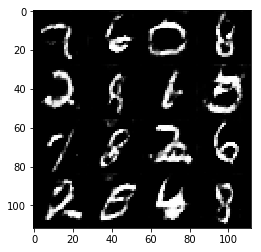

Epoch (  1/2  ) Steps ( 3400) Discriminator vs Generator Loss:  0.5264 vs  1.3600
Generated images


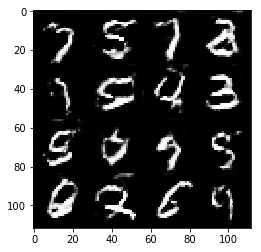

Epoch (  1/2  ) Steps ( 3500) Discriminator vs Generator Loss:  1.1072 vs  0.5057
Generated images


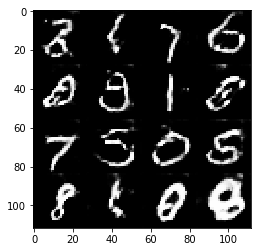

Epoch (  1/2  ) Steps ( 3600) Discriminator vs Generator Loss:  1.5290 vs  1.3163
Generated images


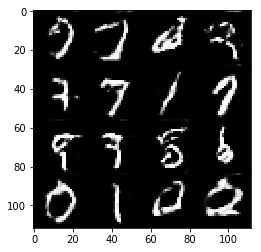

Epoch (  1/2  ) Steps ( 3700) Discriminator vs Generator Loss:  0.7300 vs  1.8180
Generated images


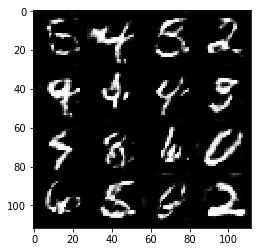

Epoch (  2/2  ) Steps ( 3800) Discriminator vs Generator Loss:  1.4467 vs  1.7179
Generated images


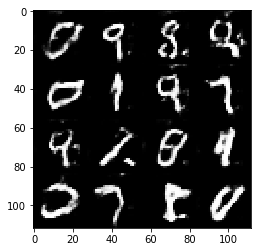

Epoch (  2/2  ) Steps ( 3900) Discriminator vs Generator Loss:  0.9533 vs  0.5497
Generated images


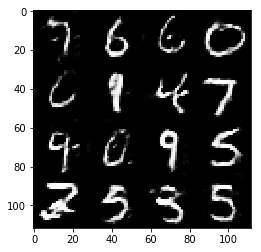

Epoch (  2/2  ) Steps ( 4000) Discriminator vs Generator Loss:  1.5132 vs  0.9919
Generated images


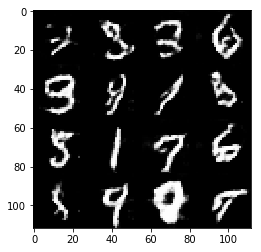

Epoch (  2/2  ) Steps ( 4100) Discriminator vs Generator Loss:  0.7599 vs  1.0186
Generated images


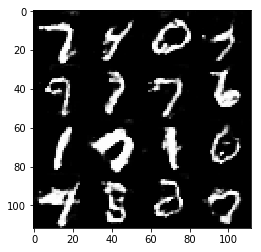

Epoch (  2/2  ) Steps ( 4200) Discriminator vs Generator Loss:  0.6463 vs  1.1161
Generated images


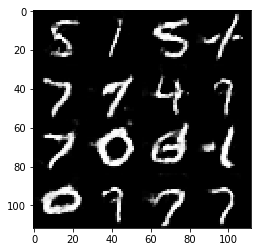

Epoch (  2/2  ) Steps ( 4300) Discriminator vs Generator Loss:  0.6982 vs  1.7107
Generated images


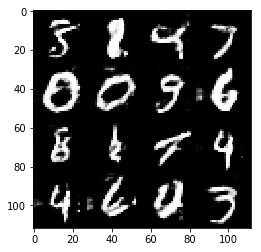

Epoch (  2/2  ) Steps ( 4400) Discriminator vs Generator Loss:  1.2089 vs  0.6404
Generated images


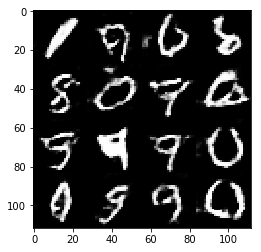

Epoch (  2/2  ) Steps ( 4500) Discriminator vs Generator Loss:  1.3312 vs  2.2709
Generated images


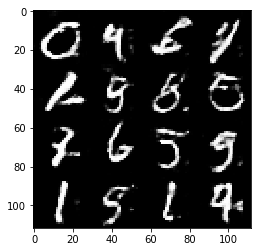

Epoch (  2/2  ) Steps ( 4600) Discriminator vs Generator Loss:  0.9606 vs  1.3369
Generated images


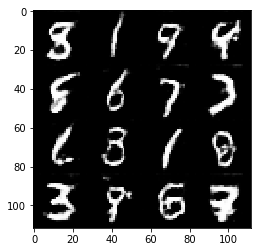

Epoch (  2/2  ) Steps ( 4700) Discriminator vs Generator Loss:  1.0618 vs  1.2507
Generated images


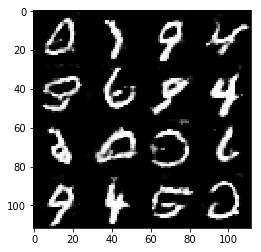

Epoch (  2/2  ) Steps ( 4800) Discriminator vs Generator Loss:  0.8353 vs  1.1620
Generated images


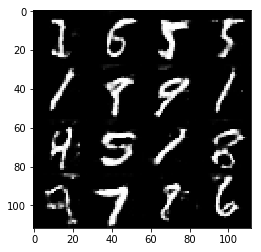

Epoch (  2/2  ) Steps ( 4900) Discriminator vs Generator Loss:  1.3131 vs  1.2325
Generated images


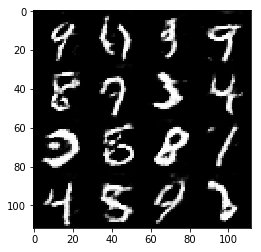

Epoch (  2/2  ) Steps ( 5000) Discriminator vs Generator Loss:  0.7165 vs  1.1490
Generated images


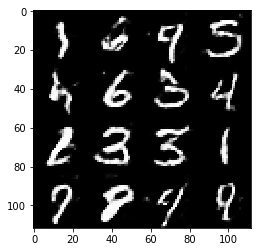

Epoch (  2/2  ) Steps ( 5100) Discriminator vs Generator Loss:  0.9830 vs  1.3647
Generated images


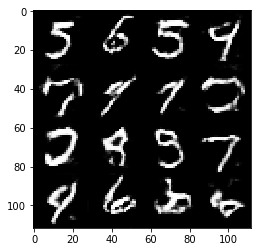

Epoch (  2/2  ) Steps ( 5200) Discriminator vs Generator Loss:  0.6092 vs  0.9189
Generated images


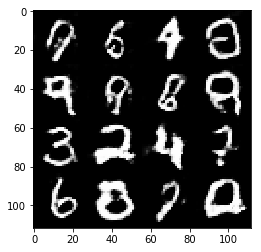

Epoch (  2/2  ) Steps ( 5300) Discriminator vs Generator Loss:  1.3270 vs  0.7697
Generated images


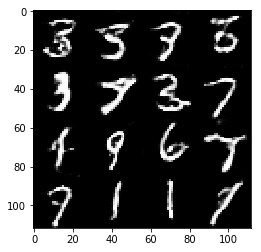

Epoch (  2/2  ) Steps ( 5400) Discriminator vs Generator Loss:  0.6822 vs  1.6337
Generated images


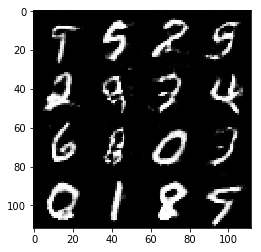

Epoch (  2/2  ) Steps ( 5500) Discriminator vs Generator Loss:  1.4355 vs  2.8429
Generated images


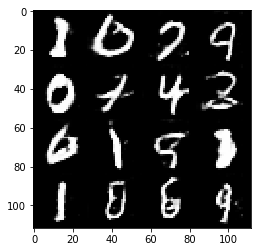

Epoch (  2/2  ) Steps ( 5600) Discriminator vs Generator Loss:  1.0240 vs  1.7827
Generated images


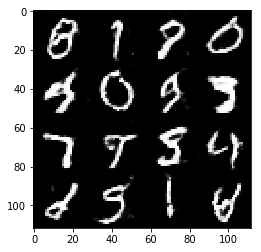

Epoch (  2/2  ) Steps ( 5700) Discriminator vs Generator Loss:  0.4912 vs  1.5744
Generated images


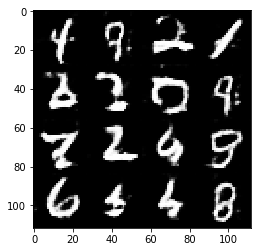

Epoch (  2/2  ) Steps ( 5800) Discriminator vs Generator Loss:  0.7725 vs  1.2758
Generated images


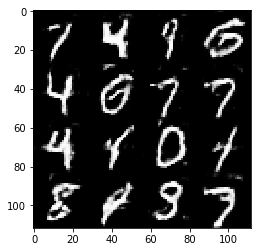

Epoch (  2/2  ) Steps ( 5900) Discriminator vs Generator Loss:  1.0038 vs  1.2040
Generated images


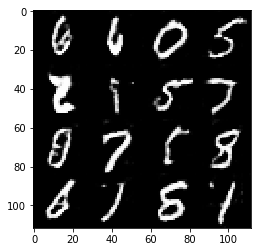

Epoch (  2/2  ) Steps ( 6000) Discriminator vs Generator Loss:  0.5290 vs  2.1769
Generated images


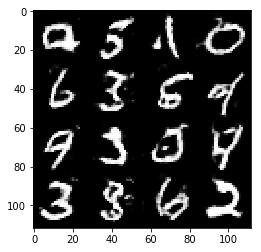

Epoch (  2/2  ) Steps ( 6100) Discriminator vs Generator Loss:  0.4786 vs  1.8819
Generated images


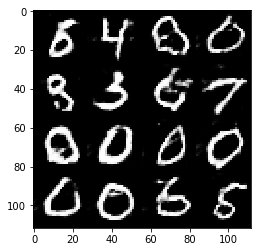

Epoch (  2/2  ) Steps ( 6200) Discriminator vs Generator Loss:  0.5410 vs  1.5379
Generated images


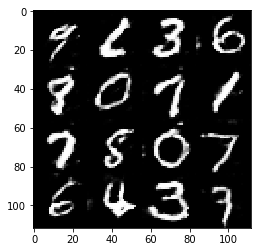

Epoch (  2/2  ) Steps ( 6300) Discriminator vs Generator Loss:  0.9304 vs  2.2578
Generated images


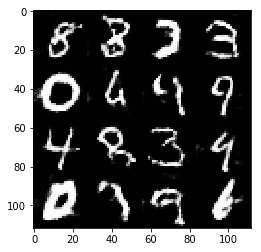

Epoch (  2/2  ) Steps ( 6400) Discriminator vs Generator Loss:  0.9152 vs  2.8941
Generated images


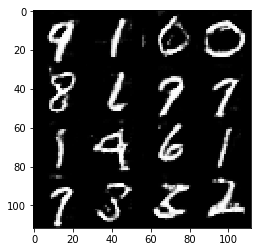

Epoch (  2/2  ) Steps ( 6500) Discriminator vs Generator Loss:  0.5573 vs  1.3262
Generated images


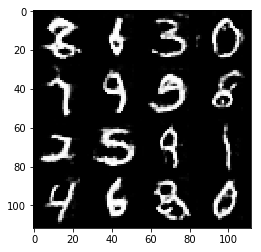

Epoch (  2/2  ) Steps ( 6600) Discriminator vs Generator Loss:  0.7354 vs  2.1745
Generated images


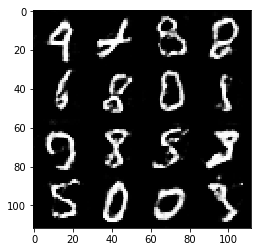

Epoch (  2/2  ) Steps ( 6700) Discriminator vs Generator Loss:  1.0861 vs  1.4919
Generated images


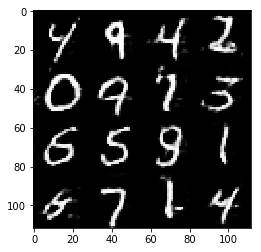

Epoch (  2/2  ) Steps ( 6800) Discriminator vs Generator Loss:  1.9091 vs  0.7777
Generated images


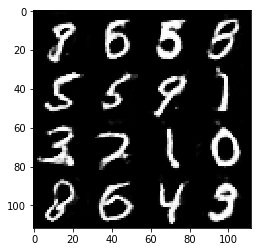

Epoch (  2/2  ) Steps ( 6900) Discriminator vs Generator Loss:  0.5304 vs  2.2548
Generated images


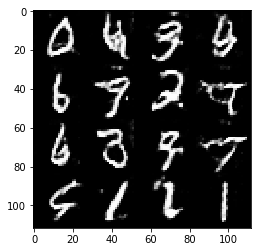

Epoch (  2/2  ) Steps ( 7000) Discriminator vs Generator Loss:  0.7941 vs  1.5478
Generated images


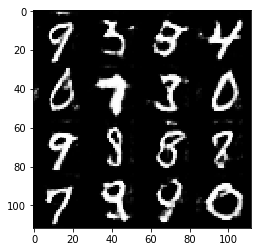

Epoch (  2/2  ) Steps ( 7100) Discriminator vs Generator Loss:  0.4653 vs  0.5066
Generated images


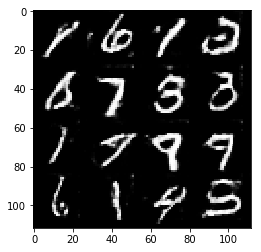

Epoch (  2/2  ) Steps ( 7200) Discriminator vs Generator Loss:  1.3395 vs  0.5780
Generated images


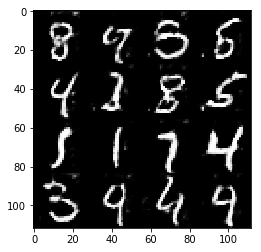

Epoch (  2/2  ) Steps ( 7300) Discriminator vs Generator Loss:  0.4945 vs  0.9046
Generated images


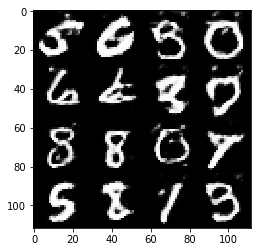

Epoch (  2/2  ) Steps ( 7400) Discriminator vs Generator Loss:  0.6194 vs  1.8416
Generated images


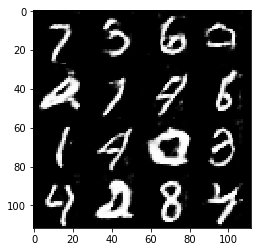

Epoch (  2/2  ) Steps ( 7500) Discriminator vs Generator Loss:  0.7253 vs  1.4321
Generated images


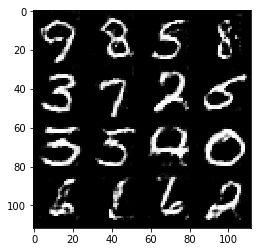

Done training, final images generated by model:


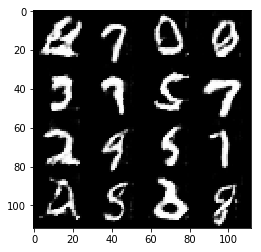

In [111]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch (  1/1  ) Steps (  100) Discriminator vs Generator Loss:  1.1181 vs  1.6699
Generated images


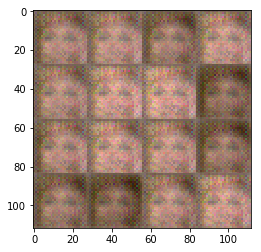

Epoch (  1/1  ) Steps (  200) Discriminator vs Generator Loss:  1.5382 vs  1.2269
Generated images


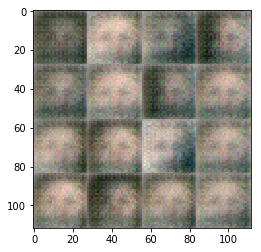

Epoch (  1/1  ) Steps (  300) Discriminator vs Generator Loss:  1.4628 vs  1.0334
Generated images


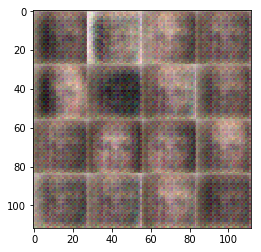

Epoch (  1/1  ) Steps (  400) Discriminator vs Generator Loss:  1.5153 vs  0.9398
Generated images


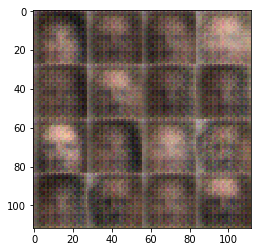

Epoch (  1/1  ) Steps (  500) Discriminator vs Generator Loss:  1.3919 vs  0.8609
Generated images


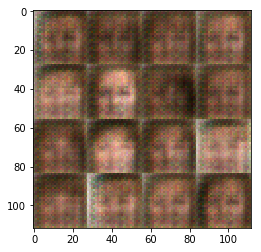

Epoch (  1/1  ) Steps (  600) Discriminator vs Generator Loss:  1.4067 vs  0.9878
Generated images


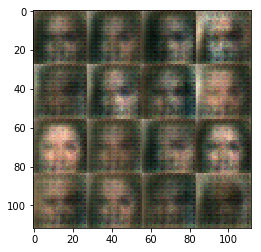

Epoch (  1/1  ) Steps (  700) Discriminator vs Generator Loss:  1.4347 vs  0.8781
Generated images


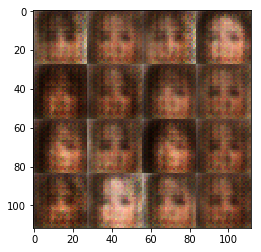

Epoch (  1/1  ) Steps (  800) Discriminator vs Generator Loss:  1.3999 vs  0.8612
Generated images


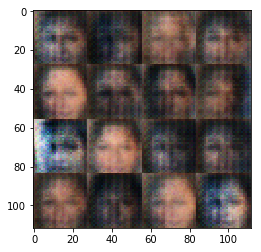

Epoch (  1/1  ) Steps (  900) Discriminator vs Generator Loss:  1.4469 vs  0.8904
Generated images


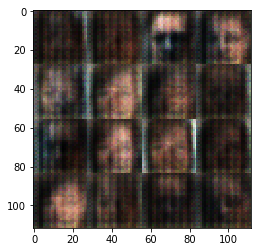

Epoch (  1/1  ) Steps ( 1000) Discriminator vs Generator Loss:  1.3865 vs  0.9398
Generated images


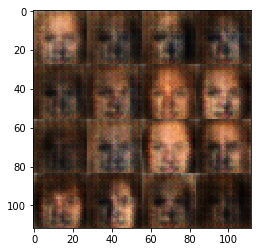

Epoch (  1/1  ) Steps ( 1100) Discriminator vs Generator Loss:  1.3772 vs  0.8301
Generated images


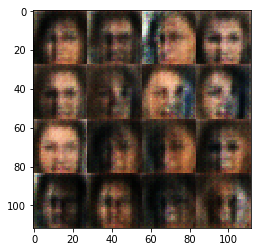

Epoch (  1/1  ) Steps ( 1200) Discriminator vs Generator Loss:  1.3501 vs  0.8332
Generated images


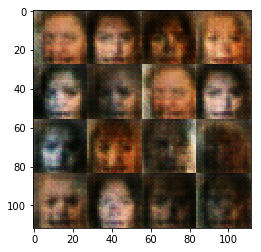

Epoch (  1/1  ) Steps ( 1300) Discriminator vs Generator Loss:  1.3942 vs  0.8547
Generated images


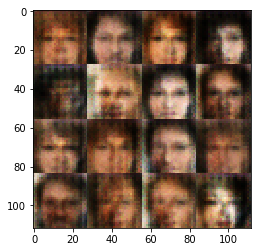

Epoch (  1/1  ) Steps ( 1400) Discriminator vs Generator Loss:  1.4300 vs  0.8257
Generated images


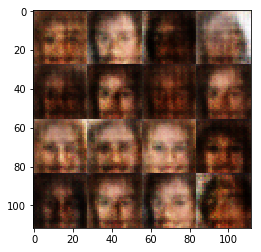

Epoch (  1/1  ) Steps ( 1500) Discriminator vs Generator Loss:  1.3734 vs  0.8170
Generated images


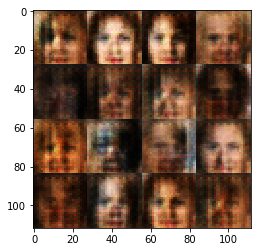

Done training, final images generated by model:


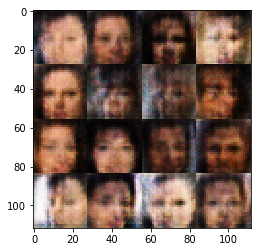

In [115]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

## Experimenting

### Model structure
Following reviewer, I have made following change to model structure
* discrimator: use 4 conv2d layer + batch-norm + leaky_relu + dropout (keep_prob=0.75)
* generator: use 4 conv2d_transpose layer + batch-norm + leaky_relu
* weigh-init: use xavier initializer

After doing this, I tried various hyperparameter settings on MNIST but model didn't improved. The images generated after 2 epochs are not really like hand-written and almost black as following

<img src="assets/mnist_bs_16_lr_2e-4_layers_bn.png" alt="mnist_bs16_lr2e-4" style="width:228px;height:228px;">

I start looking through forum on slack: current I use tf.layers.batch_norm, but others use `tf.contrib.layers.batch_norm` + enforce update-ops in the training which seems working better. So I change to use `tf.contrib.layers.batch_norm`: the result seems improved quite a bit.

### Training
I look at reviewer's links and found in [here in function train](https://github.com/carpedm20/DCGAN-tensorflow/blob/master/model.py), each training step they run train-op for generator twice which is a good idea.

This change is the one gives a major improvement.

### Hyperparameter tuning
As suggested by reviewer to use smaller batch_size, so I tried
* MNIST:  16, 32, 64, 128
* CelebA: 16, 32, 64, 128

#### MNIST
Keeping learning-rate=2e-4, I obtained after 2 epochs for MNIST 

| batch_size | d-loss | g-loss |  final-image |
|:----------:|:------:|:------:|--------------|
|  16        | 0.7964 | 1.3601 | <img src="assets/mnist_bs_16_lr_2e-4.png" alt="mnist_bs16_lr2e-4" style="width:228px;height:228px;">  |
|  32        | 0.9238 | 1.6775 | <img src="assets/mnist_bs_32_lr_2e-4.png" alt="mnist_bs32_lr2e-4" style="width:228px;height:228px;">  |
|  64        | 0.8286 | 1.4208 | <img src="assets/mnist_bs_64_lr_2e-4.png" alt="mnist_bs32_lr2e-4" style="width:228px;height:228px;">  |
|  128       | 0.8274 | 2.1924 | <img src="assets/mnist_bs_128_lr_2e-4.png" alt="mnist_bs32_lr2e-4" style="width:228px;height:228px;"> |
Note here, the result is changed each run but MNIST, it seems **batch-size = 16 or 32** seems reasonable choices.

I also notice that the d-loss, g-loss are flipping around during 2 epochs training. I look in the internet and it seems that it's expected. 

#### Celab

| batch_size | d-loss | g-loss |  final-image |
|:----------:|:------:|:------:|--------------|
|  16        | 1.3962 | 0.8523 | <img src="assets/celab_bs_16_lr_2e-4.png" alt="mnist_bs16_lr2e-4" style="width:228px;height:228px;">  |
|  32        | 1.4047 |  0.8018 | <img src="assets/celab_bs_32_lr_2e-4.png" alt="mnist_bs32_lr2e-4" style="width:228px;height:228px;">  |
|  64        | 1.3740 |  0.7894 | <img src="assets/celab_bs_64_lr_2e-4.png" alt="mnist_bs32_lr2e-4" style="width:228px;height:228px;">  |
|  128       | 1.3734 |  0.8170 | <img src="assets/celab_bs_128_lr_2e-4.png" alt="mnist_bs32_lr2e-4" style="width:228px;height:228px;"> |

For Celab, it seems both 16,32 and 64 are working fine.

### Conclusion
Training GAN is quite tough due to a lot of training parameters and the consuming time but it's very interesting to see it works.